In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = '../../Smart attack Algorithm/data/Car Hacking Dataset/'
attack_data_path = os.path.join(data_path, 'DoS_dataset.csv')
perturbed_data_path = 'Adversarial_traffic_Both.csv'

In [3]:
def shift_columns(df):
    
    for dlc in [2,5,6]:

        df.loc[df['DLC'] == dlc, df.columns[3:]] = df.loc[df['DLC'] == dlc, df.columns[3:]].shift(periods=8-dlc, axis='columns', fill_value='00')

    return df
    

def read_ch_data(data_path):
    
    columns = ['Timestamp','ID', 'DLC', 'data0', 'data1', 'data2', 'data3', 'data4', 
           'data5', 'data6', 'data7', 'label']
    
    data = pd.read_csv(data_path, names = columns)

    data = shift_columns(data)
    
    ##Replacing all NaNs with '00' 
    data = data.replace(np.NaN, '00')
    
    ##Joining all data columns to put all data in one column
    data_cols = ['data0', 'data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7']
    
    ##The data column is in hexadecimal
    data['Data'] = data[data_cols].apply(''.join, axis=1)
    data.drop(columns = data_cols, inplace = True, axis = 1)
        
    data = data.assign(IAT=data['Timestamp'].diff().fillna(0))
    data = data[['Timestamp', 'ID','DLC','Data', 'IAT', 'label']]
    data['label'].replace({'R' : 0, 'T' : 1}, inplace = True)
    
    return data

dos_data = read_ch_data(attack_data_path)
dos_data.head()

/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_47837/3049701719.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['label'].replace({'R' : 0, 'T' : 1}, inplace = True)
/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_47837/3049701719.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcas

,Timestamp,ID,DLC,Data,IAT,label
0,1.478198e+09,0316,8,052168092121006f,0.000000,0
1,1.478198e+09,018f,8,fe5b0000003c0000,0.000209,0
2,1.478198e+09,0260,8,19212230088e6d3a,0.000228,0
3,1.478198e+09,02a0,8,64009a1d9702bd00,0.000232,0
4,1.478198e+09,0329,8,40bb7f1411200014,0.000237,0


In [4]:
pertubed_data = pd.read_csv(perturbed_data_path)  # Adjust delimiter if needed

def construct_payload(row):
    dlc = int(row["DLC"])  # Number of valid data columns
    data_values = [row[f"Data{i}"] for i in range(1, dlc + 1) if f"Data{i}" in row]
    return "".join(map(str, data_values))

pertubed_data["Data"] = pertubed_data.apply(construct_payload, axis=1)
# Keep only the required columns
pertubed_data = pertubed_data[["TS", "ID", "DLC", "Data", "Label"]]
## Rename the columns to Timestamp, ID, DLC, Data, and Label
pertubed_data.columns = ["Timestamp", "ID", "DLC", "Data", "label"]

# Save the transformed data
# data.to_csv("transformed_file.csv", index=False)

# Display the transformed DataFrame
pertubed_data.head()

,Timestamp,ID,DLC,Data,label
0,0.000000,2fb,8,de3de7fc77d18619,2
1,0.005492,643,8,de5f417c9b4d34db,2
2,0.011240,140,8,000000001c072628,0
3,0.016786,6df,8,05b06567dfdff49d,2
4,0.017052,316,8,052174092120006f,0


In [5]:
hex_to_dec = lambda x: int(str(x), 16)

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Data'] = data['Data'].apply(hex_to_dec)

    return data

dos_data = transform_data(dos_data)

pertubed_data = transform_data(pertubed_data)
pertubed_data['label'].replace(2,1, inplace=True)
pertubed_data['label'].replace(3,1, inplace=True)


/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_47837/2497906603.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pertubed_data['label'].replace(2,1, inplace=True)
/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_47837/2497906603.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [6]:
dos_data.head()

,Timestamp,ID,DLC,Data,IAT,label
0,1.478198e+09,790,8,369691032840896623,0.000000,0
1,1.478198e+09,399,8,18328243108518297600,0.000209,0
2,1.478198e+09,608,8,1810766114876976442,0.000228,0
3,1.478198e+09,672,8,7205928855671061760,0.000232,0
4,1.478198e+09,809,8,4664461563235663892,0.000237,0


In [7]:
pertubed_data.head()

,Timestamp,ID,DLC,Data,label
0,0.000000,763,8,16014210921527346713,1
1,0.005492,1603,8,16023598002644792539,1
2,0.011240,320,8,470230568,0
3,0.016786,1759,8,409939062902748317,1
4,0.017052,790,8,369704226980364399,0


In [8]:
def split_into_windows(df, window_size):
    """
    Split dataset into windows of a given size and assign a label to each window.
    
    Args:
        df (pd.DataFrame): Input dataframe.
        window_size (float): Window size in seconds.
        
    Returns:
        list: List of windowed dataframes.
        list: List of labels for each window (1 if any data point in the window is 1, else 0).
        int: Number of windows.
    """
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()
    
    windows = []
    window_labels = []  # To store the label for each window
    current_time = start_time
    
    while current_time <= end_time:
        # Extract data for the current window
        window = df[(df['Timestamp'] >= current_time) & 
                    (df['Timestamp'] < current_time + window_size)]
        
        if not window.empty:
            windows.append(window)
            
            # Assign window label: 1 if any label is 1 in the window, else 0
            if (window['label'] == 1).any():
                window_labels.append(1)
            else:
                window_labels.append(0)
        
        # Move to next window
        current_time += window_size
    
    return windows, window_labels, len(windows)

def calculate_entropy(windows):
    """
    Calculate entropy for each window.
    
    Args:
        windows (list): List of windowed dataframes.
        
    Returns:
        list: List of entropy values for each window.
    """
    entropies = []
    
    for window in windows:
        # Count unique combinations of Identifier, Data Length Code, and Data
        counts = window.groupby(['ID', 'DLC', 'Data']).size()
        total = counts.sum()
        
        if total > 0:
            # Compute probability
            probabilities = counts / total
            
            # Calculate entropy using the definition
            entropy = -np.sum(probabilities * np.log2(probabilities))
            entropies.append(entropy)
    
    return entropies

In [9]:
# entropy_dict = {}  # Dictionary to store entropy values by window size
# window_labels_dict = {}  # Stores window labels by window size

# window_sizes = [1, 0.5, 0.1]  # in seconds
# for window_size in window_sizes:
#     windows, window_labels, num_windows = split_into_windows(benign_data, window_size)
#     entropies = calculate_entropy(windows)
    
#     # Store entropy values in dictionary
#     entropy_dict[window_size] = entropies
#     window_labels_dict[window_size] = window_labels

    
#     print(f"Window size: {window_size} seconds")
#     print(f"Number of windows: {num_windows}")
#     print(f"Average entropy: {np.mean(entropies):.4f}\n")

# # Example: Access entropy values later
# print(entropy_dict[1])  # Entropy values for window size 1 second


def plot_entropy(entropy_dict, window_labels_dict, show_labels=True):
    """
    Plots entropy across time windows. If show_labels is True, creates separate plots 
    for each window size, distinguishing attack (label=1) and benign (label=0) windows.

    Args:
        entropy_dict (dict): Dictionary mapping window size to entropy values.
        window_labels_dict (dict): Dictionary mapping window size to window labels.
        show_labels (bool): Whether to plot attack and benign windows separately.
    """
    
    if show_labels:
        for window_size, entropies in entropy_dict.items():
            labels = window_labels_dict[window_size]
            x = np.arange(len(entropies))  # X-axis: Window indices
            
            attack_indices = [idx for idx, lbl in enumerate(labels) if lbl == 1]
            benign_indices = [idx for idx, lbl in enumerate(labels) if lbl == 0]

            plt.figure(figsize=(10, 5))
            
            plt.scatter(attack_indices, [entropies[idx] for idx in attack_indices], 
                        color='red', label='Attack', marker='x')

            plt.scatter(benign_indices, [entropies[idx] for idx in benign_indices], 
                        color='blue', label='Benign', marker='o')

            plt.title(f'Entropy Across Time Windows - Window Size {window_size}s')
            plt.xlabel('Window Index')
            plt.ylabel('Entropy')
            plt.legend()
            plt.grid(True)
            plt.show()

    else:
        plt.figure(figsize=(12, 6))
        colors = ['blue', 'green', 'red']  # Colors for each window size
        
        for i, (window_size, entropies) in enumerate(entropy_dict.items()):
            x = np.arange(len(entropies))  # X-axis: Window indices
            plt.plot(x, entropies, label=f'Window size: {window_size}s', 
                     color=colors[i % len(colors)], marker='o', linestyle='-')

        #
        plt.xlabel('Window Index')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True)
        plt.show()


In [10]:
def data_len(df):
    if 'Timestamp' in df.columns:
        # Ensure the Timestamp column is sorted
        df = df.sort_values(by='Timestamp')
        
        # Compute time difference
        time_diff = df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]
        
        # Convert to HH:MM:SS:Milliseconds format
        hours, remainder = divmod(time_diff, 3600)
        minutes, remainder = divmod(remainder, 60)
        seconds, milliseconds = divmod(remainder, 1)
        
        time_str = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}:{int(milliseconds * 1000):03}"
        
        return time_str
    else:
        return "Timestamp column not found in dataframe"

In [11]:
##Because perturbed_data has some data from dos_data
dos_data = dos_data.iloc[len(dos_data)//2: ]

##Only keep the datapoints having label 0 in dos_data
dos_data = dos_data[dos_data['label'] == 0]

In [12]:
train_data, val_data = train_test_split(dos_data, test_size = 0.5, shuffle = False)

In [13]:
data_len(train_data)

'00:13:39:282'

In [14]:
data_len(val_data)

'00:07:24:965'

In [15]:
data_len(pertubed_data)

'00:01:06:877'

In [16]:
print(train_data['label'].unique())
print(val_data['label'].unique())

[0]
[0]


In [17]:
## For finding mean and std-dev

print("Train data")

entropy_dict = {}  # Dictionary to store entropy values by window size
window_labels_dict = {}  # Stores window labels by window size

window_sizes = [1, 0.5, 0.1]  # in seconds
for window_size in window_sizes:
    windows, window_labels, num_windows = split_into_windows(train_data, window_size)
    entropies = calculate_entropy(windows)
    
    # Store entropy values in dictionary
    entropy_dict[window_size] = entropies
    window_labels_dict[window_size] = window_labels

    
    print(f"Window size: {window_size} seconds")
    print(f"Number of windows: {num_windows}")
    print(f"Average entropy: {np.mean(entropies):.4f}\n")

print('\n\n\n\n')

print("Validation data")

val_entropy_dict = {}  # Dictionary to store entropy values by window size
val_window_labels_dict = {}  # Stores window labels by window size

window_sizes = [1, 0.5, 0.1]  # in seconds
for window_size in window_sizes:
    val_windows, val_window_labels, val_num_windows = split_into_windows(val_data, window_size)
    val_entropies = calculate_entropy(val_windows)
    
    # Store entropy values in dictionary
    val_entropy_dict[window_size] = val_entropies
    val_window_labels_dict[window_size] = val_window_labels

    
    print(f"Window size: {window_size} seconds")
    print(f"Number of windows: {val_num_windows}")
    print(f"Average entropy: {np.mean(val_entropies):.4f}\n")


Train data
Window size: 1 seconds
Number of windows: 799
Average entropy: 6.8773

Window size: 0.5 seconds
Number of windows: 1595
Average entropy: 6.4395

Window size: 0.1 seconds
Number of windows: 7968
Average entropy: 5.1797






Validation data
Window size: 1 seconds
Number of windows: 445
Average entropy: 7.3436

Window size: 0.5 seconds
Number of windows: 890
Average entropy: 7.0015

Window size: 0.1 seconds
Number of windows: 4450
Average entropy: 6.0492



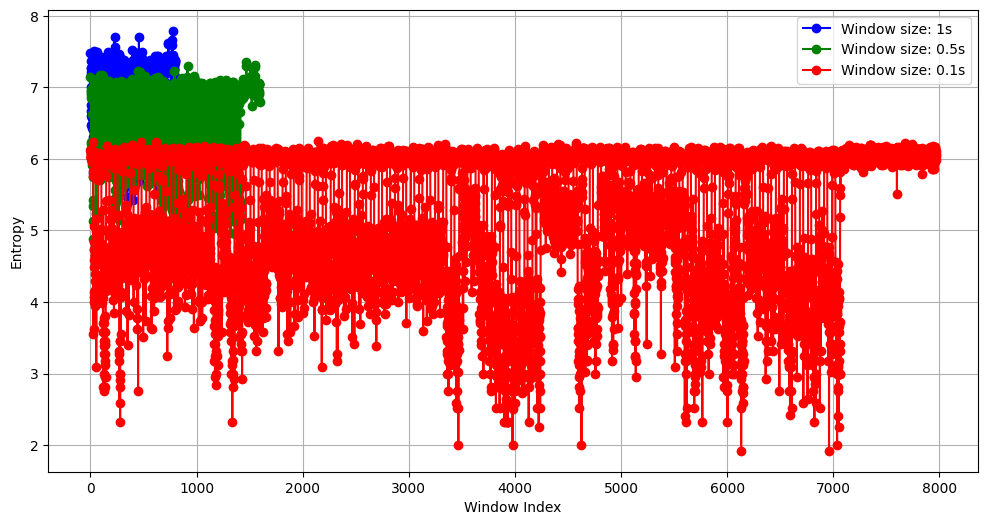

In [18]:
plot_entropy(entropy_dict, window_labels_dict, show_labels=False) 

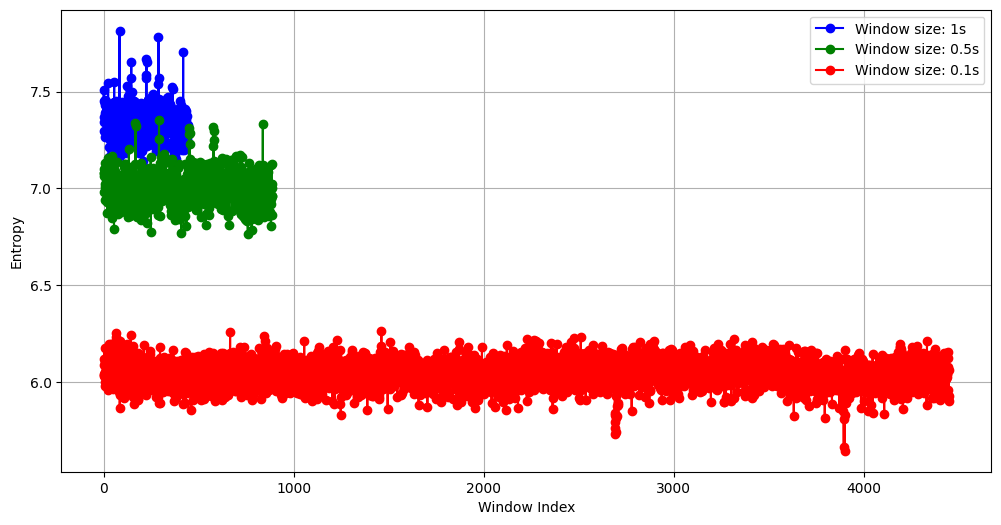

In [19]:
plot_entropy(val_entropy_dict, val_window_labels_dict, show_labels=False) 

In [11]:
# entropy_dict[1]

In [12]:
# entropy_dict

In [21]:
window_1_labels = window_labels_dict[1]
window05_labels = window_labels_dict[0.5]
window01_labels = window_labels_dict[0.1]

val_window_1_labels = val_window_labels_dict[1]
val_window05_labels = val_window_labels_dict[0.5]
val_window_01_labels = val_window_labels_dict[0.1]


In [ ]:
# print("Length of window_1: ", len(window_1_labels))
# print("Length of window05: ", len(window05_labels))
# print("Length of window01: ", len(window01_labels))

Length of window_1:  1244
Length of window05:  2485
Length of window01:  12418


In [35]:
test_entropy_dict = {}  # Dictionary to store entropy values by window size
test_window_labels_dict = {}  # Stores window labels by window size

window_sizes = [1, 0.5, 0.1]  # in seconds
for window_size in window_sizes:
    windows, window_labels, num_windows = split_into_windows(pertubed_data, window_size)
    entropies = calculate_entropy(windows)
    
    # Store entropy values in dictionary
    test_entropy_dict[window_size] = entropies
    test_window_labels_dict[window_size] = window_labels
    
    print(f"Window size: {window_size} seconds")
    print(f"Number of windows: {num_windows}")
    print(f"Average entropy: {np.mean(entropies):.4f}\n")

    #Write code to group by window label and print number of windows and average entropy by window label
    # Group by window label
    test_window_label_counts = pd.Series(window_labels).value_counts()
    test_window_label_avg_entropy = pd.Series(entropies).groupby(window_labels).mean()
    test_window_label_std_entropy = pd.Series(entropies).groupby(window_labels).std()
    # print(window_label_counts)
    # print(window_label_avg_entropy)
    print("Number of attack windows: ", test_window_label_counts[1])
    print("Number of benign windows: ", test_window_label_counts[0])
    print()
    print(f"Mean and std-dev of entropy for attack windows: {test_window_label_avg_entropy[1]} and {test_window_label_std_entropy[1]}")
    print(f"Mean and std-dev of entropy for benign windows: {test_window_label_avg_entropy[0]} and {test_window_label_std_entropy[1]}") 
    print('\n\n\n')


Window size: 1 seconds
Number of windows: 67
Average entropy: 7.5850

Number of attack windows:  47
Number of benign windows:  20

Mean and std-dev of entropy for attack windows: 7.689576427905707 and 0.3405140992938431
Mean and std-dev of entropy for benign windows: 7.339361552314218 and 0.3405140992938431




Window size: 0.5 seconds
Number of windows: 134
Average entropy: 7.0391

Number of attack windows:  85
Number of benign windows:  49

Mean and std-dev of entropy for attack windows: 7.06755154498601 and 0.2842647840632147
Mean and std-dev of entropy for benign windows: 6.989723836884765 and 0.2842647840632147




Window size: 0.1 seconds
Number of windows: 669
Average entropy: 5.6298

Number of attack windows:  387
Number of benign windows:  282

Mean and std-dev of entropy for attack windows: 5.343378850601073 and 0.39354463808024476
Mean and std-dev of entropy for benign windows: 6.022973758880237 and 0.39354463808024476






In [23]:
test_window_1_labels = test_window_labels_dict[1]
test_window05_labels = test_window_labels_dict[0.5]
test_window01_labels = test_window_labels_dict[0.1]

print("Length of test_window_1: ", len(test_window_1_labels))
print("Length of test_window05: ", len(test_window05_labels))
print("Length of test_window01: ", len(test_window01_labels))

Length of test_window_1:  67
Length of test_window05:  134
Length of test_window01:  669


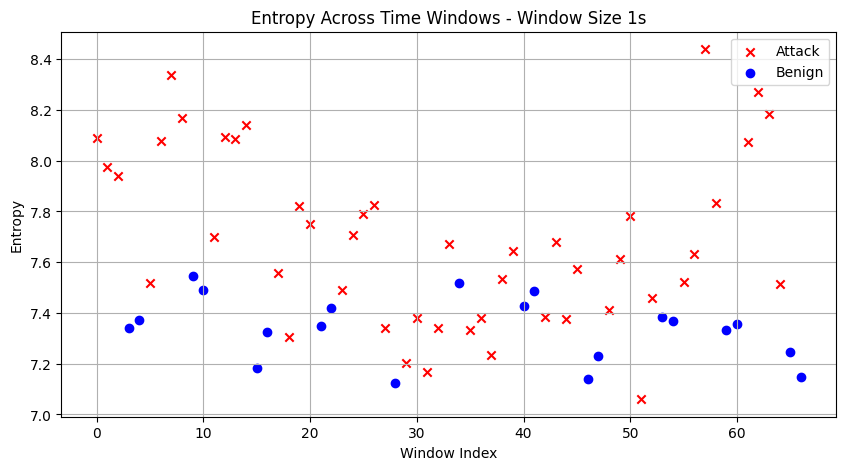

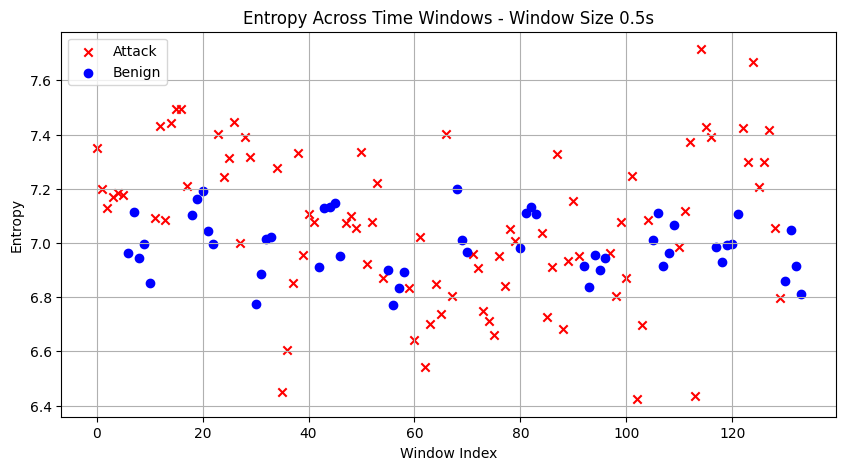

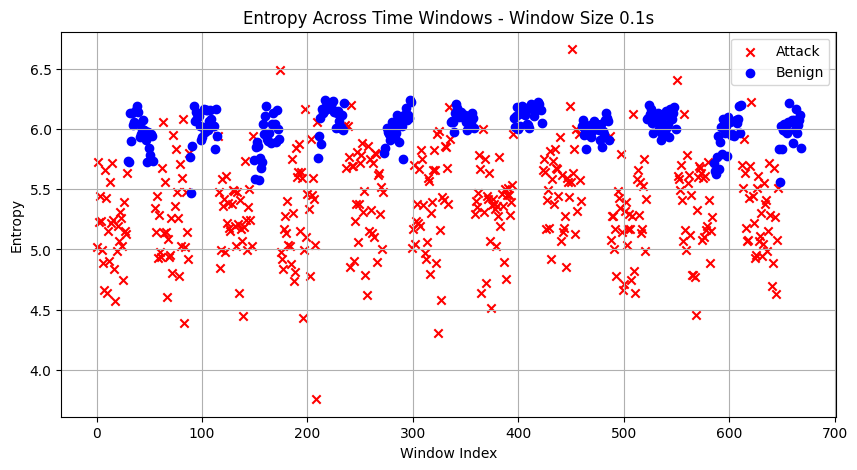

In [31]:
plot_entropy(test_entropy_dict, test_window_labels_dict, show_labels=True)

In [32]:
def detect_attack(entropy, threshold):
    """
    Detects attack based on entropy values and threshold.
    
    Args:
        entropy (list): Entropy list.
        threshold (list): Lower and upper threshold values.
        
    Returns:
        predicted_labels (list): List of predicted labels (1 if attack, else 0).
    """
    predicted_labels = []
    
    for e in entropy:
        if e < threshold[0] or e > threshold[1]:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    
    return predicted_labels

In [33]:
# ## Write code to find median and std dev of each window size from the training set

mean_window_01, std_dev_window_01 = np.mean(entropy_dict[0.1]), np.std(entropy_dict[0.1])
mean_window_05, std_dev_window_05 = np.mean(entropy_dict[0.5]), np.std(entropy_dict[0.5])
mean_window_1, std_dev_window_1 = np.mean(entropy_dict[1]), np.std(entropy_dict[1])

fp_dict = {0.1: None, 0.5: None, 1: None}  # Dictionary to store the first k where FP turns 0

k_list = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]


for k in k_list:

    print("Currently on k =", k)

    # Define thresholds
    threshold_01 = [mean_window_01 - k * std_dev_window_01, mean_window_01 + k * std_dev_window_01]
    threshold_05 = [mean_window_05 - k * std_dev_window_05, mean_window_05 + k * std_dev_window_05]
    threshold_1 = [mean_window_1 - k * std_dev_window_1, mean_window_1 + k * std_dev_window_1]

    # Get predictions
    val_preds_01 = detect_attack(val_entropy_dict[0.1], threshold_01)
    val_preds_05 = detect_attack(val_entropy_dict[0.5], threshold_05)
    val_preds_1 = detect_attack(val_entropy_dict[1], threshold_1)

    # Calculate false positives
    num_false_positives_01 = sum((np.array(val_window_labels_dict[0.1]) == 0) & (np.array(val_preds_01) == 1))
    num_false_positives_05 = sum((np.array(val_window_labels_dict[0.5]) == 0) & (np.array(val_preds_05) == 1))
    num_false_positives_1 = sum((np.array(val_window_labels_dict[1]) == 0) & (np.array(val_preds_1) == 1))

    print(f"Number of false positives for window size 0.1: {num_false_positives_01}")
    print(f"Number of false positives for window size 0.5: {num_false_positives_05}")
    print(f"Number of false positives for window size 1: {num_false_positives_1}\n")

    # Track first k when false positives become zero
    if num_false_positives_01 == 0 and fp_dict[0.1] is None:
        fp_dict[0.1] = k
    if num_false_positives_05 == 0 and fp_dict[0.5] is None:
        fp_dict[0.5] = k
    if num_false_positives_1 == 0 and fp_dict[1] is None:
        fp_dict[1] = k

    if num_false_positives_01 == 0 and num_false_positives_05 == 0 and num_false_positives_1 == 0:
        print("All false positives are zero. Stopping the search.")
        break

    ## For all window sizes write code to plot ROC curve for k values
    

print("First k values where false positives turn 0:", fp_dict)

Currently on k = 0.1
Number of false positives for window size 0.1: 4450
Number of false positives for window size 0.5: 890
Number of false positives for window size 1: 445

Currently on k = 0.2
Number of false positives for window size 0.1: 4450
Number of false positives for window size 0.5: 890
Number of false positives for window size 1: 445

Currently on k = 0.4
Number of false positives for window size 0.1: 4450
Number of false positives for window size 0.5: 890
Number of false positives for window size 1: 445

Currently on k = 0.5
Number of false positives for window size 0.1: 4449
Number of false positives for window size 0.5: 890
Number of false positives for window size 1: 445

Currently on k = 0.6
Number of false positives for window size 0.1: 4446
Number of false positives for window size 0.5: 885
Number of false positives for window size 1: 436

Currently on k = 0.8
Number of false positives for window size 0.1: 4282
Number of false positives for window size 0.5: 768
Number

In [34]:
# ## Create a dictionary for mean and std dev for each window size
mean_std_dict = {
    0.1: (mean_window_01, std_dev_window_01),
    0.5: (mean_window_05, std_dev_window_05),
    1: (mean_window_1, std_dev_window_1)
}

In [36]:
def evaluate(test_entropy_dict, test_window_labels_dict, mean_std_dict, fp_dict):

    
    for window_size in test_entropy_dict.keys():
        print("Currently on window size =", window_size)

        # Define thresholds
        mean, std_dev = mean_std_dict[window_size]
        k = fp_dict[window_size]
        threshold = [mean - k * std_dev, mean + k * std_dev]
        print("Threshold: ", threshold)

        # Get true labels
        y_true = test_window_labels_dict[window_size]

        # Get predictions
        y_pred = detect_attack(test_entropy_dict[window_size], threshold)

        accuracy = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        ##Write code to find absolute number of true positives, false positives, true negatives and false negatives in comparison to actual positive and negative labels
        true_positives = sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
        false_positives = sum((np.array(y_true) == 0) & (np.array(y_pred) == 1))
        true_negatives = sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
        false_negatives = sum((np.array(y_true) == 1) & (np.array(y_pred) == 0))

        print(f"True Positives / All Positives : {true_positives} / {true_positives + false_negatives} ({true_positives / (true_positives + false_negatives):.4f})")
        print(f"False Positives / All Negatives : {false_positives} / {false_positives + true_negatives} ({false_positives / (false_positives + true_negatives):.4f})")
        print(f"True Negatives / All Negatives : {true_negatives} / {false_positives + true_negatives} ({true_negatives / (false_positives + true_negatives):.4f})")
        print(f"False Negatives / All Positives : {false_negatives} / {true_positives + false_negatives} ({false_negatives / (true_positives + false_negatives):.4f})")
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

Currently on window size = 1
Threshold:  [5.902219385694671, 7.85237460737298]
Accuracy: 0.4925

Classification Report:
               precision    recall  f1-score   support

           0       0.37      1.00      0.54        20
           1       1.00      0.28      0.43        47

    accuracy                           0.49        67
   macro avg       0.69      0.64      0.49        67
weighted avg       0.81      0.49      0.47        67

True Positives / All Positives : 13 / 47 (0.2766)
False Positives / All Negatives : 0 / 20 (0.0000)
True Negatives / All Negatives : 20 / 20 (1.0000)
False Negatives / All Positives : 34 / 47 (0.7234)


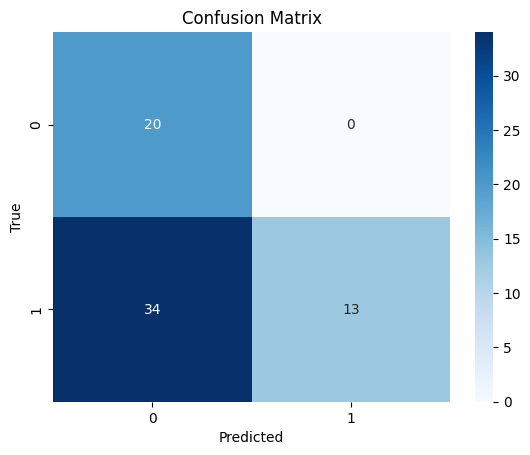

Currently on window size = 0.5
Threshold:  [5.2571367069299315, 7.621884482419435]
Accuracy: 0.3806

Classification Report:
               precision    recall  f1-score   support

           0       0.37      1.00      0.54        49
           1       1.00      0.02      0.05        85

    accuracy                           0.38       134
   macro avg       0.69      0.51      0.29       134
weighted avg       0.77      0.38      0.23       134

True Positives / All Positives : 2 / 85 (0.0235)
False Positives / All Negatives : 0 / 49 (0.0000)
True Negatives / All Negatives : 49 / 49 (1.0000)
False Negatives / All Positives : 83 / 85 (0.9765)


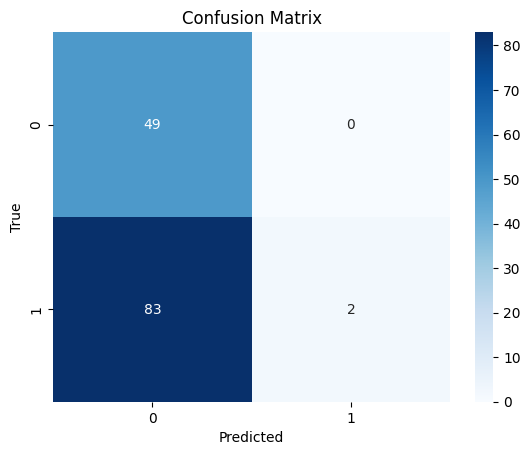

Currently on window size = 0.1
Threshold:  [3.7636345087021876, 6.595666702996995]
Accuracy: 0.4245

Classification Report:
               precision    recall  f1-score   support

           0       0.42      1.00      0.59       282
           1       1.00      0.01      0.01       387

    accuracy                           0.42       669
   macro avg       0.71      0.50      0.30       669
weighted avg       0.76      0.42      0.26       669

True Positives / All Positives : 2 / 387 (0.0052)
False Positives / All Negatives : 0 / 282 (0.0000)
True Negatives / All Negatives : 282 / 282 (1.0000)
False Negatives / All Positives : 385 / 387 (0.9948)


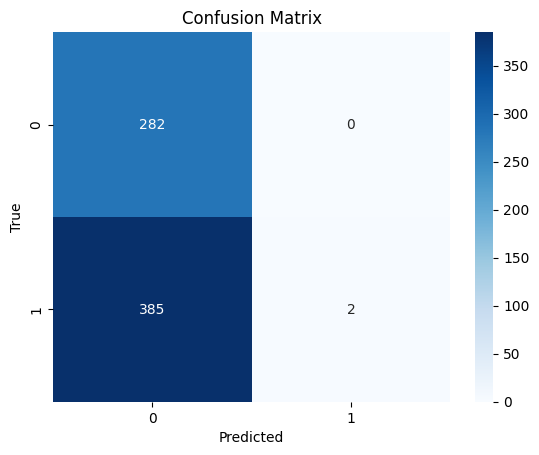

In [37]:
evaluate(test_entropy_dict, test_window_labels_dict, mean_std_dict, fp_dict)

Currently on window size = 1


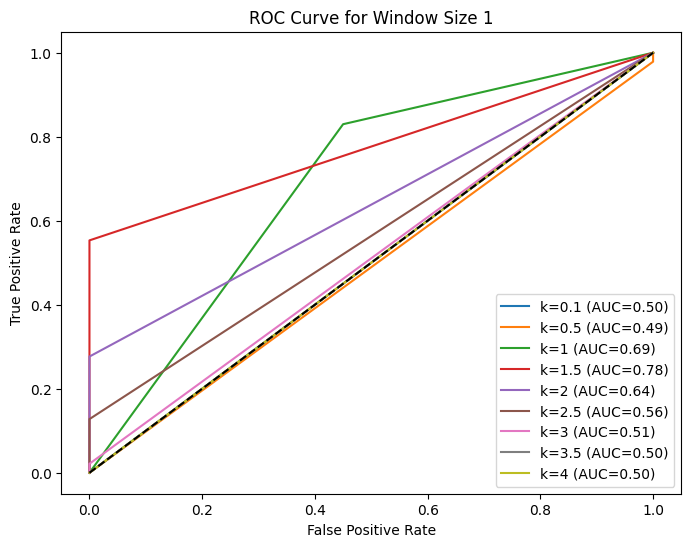

Currently on window size = 0.5


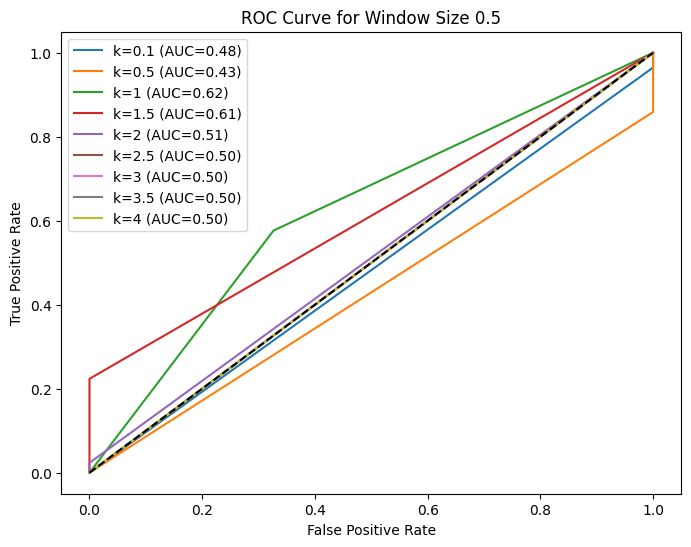

Currently on window size = 0.1


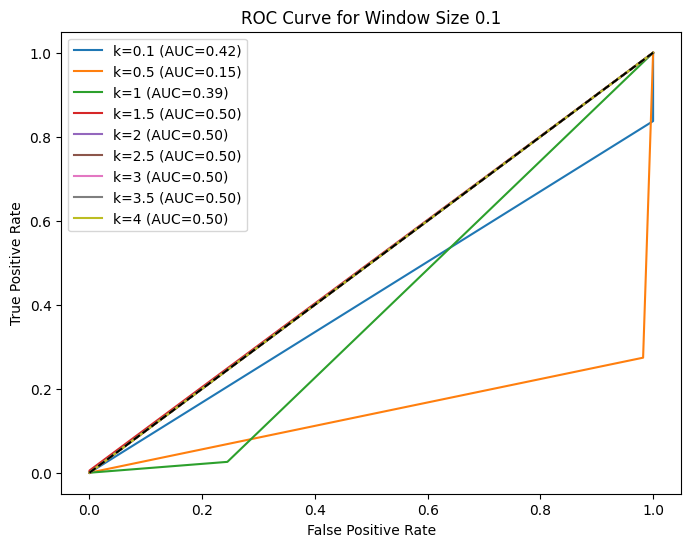

In [41]:
def roc_curves(test_entropy_dict, test_window_labels_dict, mean_std_dict):
    k_list = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

    for window_size in test_entropy_dict.keys():
        print("Currently on window size =", window_size)
        mean, std_dev = mean_std_dict[window_size]

        plt.figure(figsize=(8, 6))  # Create a new figure for each window size

        for k in k_list:
            threshold = [mean - k * std_dev, mean + k * std_dev]

            y_true = np.array(test_window_labels_dict[window_size])
            y_pred = detect_attack(test_entropy_dict[window_size], threshold)

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.plot(fpr, tpr, label=f'k={k} (AUC={roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for Window Size {window_size}")
        plt.legend()
        plt.show() 




roc_curves(test_entropy_dict, test_window_labels_dict, mean_std_dict)        